<h1>ETL planning for Brazilian Interest Rate and Inflation Rate Data Analysis</h1> 
Author: <a href=https://www.linkedin.com/in/mailson-p-92909928a/> Mailson Vieira Passos <a/>

<hr>

<h2>Table of content</h2>
<div class="alert alert-block alert-danger" style="background-color: #ffffee; margin-top: 20px; margin-left: 10px; color: black; font-size: 15px">
    <ol>
        <li><a href="#Motivation">Motivation</a></li>
        <li><a href="#Objective">Objective</a></li>
        <li><a href="#Requirements">Requirements</a></li>
        <li><a href="#ETL">ETL + pre-analysis </a></li>
            <ol>
                <li><a href="#Selic">Selic</a></li>
                <li><a href="#IPCA">IPCA</a></li>
            </ol>    
    </ol>

</div>

<h2><span id='Motivation'>Motivation</span></h2>
Lately, Brazil's interest rate has been increasing non-stop and I wanted to understand more about it. I also wanted to apply some statistical knowlegdge that I recently acquired to analyze it.

Let's begin with some definitions
</ul>

What is the Selic (interest rate)?

> The Selic rate is the reference interest rate for the Brazilian economy. It influences other rates, such as those used in loans, financing and investments. Setting a target for the Selic rate is the main monetary policy instrument used by the Banco Central do Brasil (BCB) to control inflation.  
> The Selic rate is calculated by taking the average interest rate charged on overnight operations collateralized by federal government securities traded in the local market. The BCB carries out operations in the market of government securities so that the Selic rate is in line with the target set by the Monetary Policy Committee (Copom) of the BCB   
\
Source: <a href = 'https://www.bcb.gov.br/en/monetarypolicy/selicrate'> <b>Brazilian Central Bank</b> </a>

What is the IPCA?

>The National System of Consumer Price Indexes - SNIPC continuously and systematically produces the Extended National Consumer Price Index - IPCA, aimed at measuring the inflation rate for a group of products and services from retail trade, relative to household expenditure. That income range was created in order to guarantee a 90% coverage of families living in urban areas included in the National System of Consumer Price Indexes - SNIPC.   (IBGE).  
\
Source: <a href = 'https://www.ibge.gov.br/en/statistics/economic/prices-and-costs/17129-extended-national-consumer-price-index.html?=&t=o-que-e'> <b>Brazilian Institute of Geography and Statistics (IBGE)</b> </a>


<hr>

<h2><span id='Objective'>Objective</span></h2>
<ul>
    <li>Extract the interest rate data which is available at <a href=https://www.bcb.gov.br/controleinflacao/historicotaxasjuros>Banco Central do Brasil</a> and the inflation rate that is available at <a href=https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=downloads>IBGE</a></li>
    <li>Do the necessary transformations</li>
    <li>Pre-analysis</li>
</ul>

<hr>
<h2>Requirements</h2>

```python
!pip install pandas==2.0.0
!pip install numpy==1.26.1
!pip install matplotlib==3.8.0
!pip install seaborn==0.13.2
!pip install requests==2.31.0
```
<hr>

<h2><span id='ColetaTransf'></span>ETL and pre-analysis</h2>

<h3><span id='Selic'></span>1. Selic</h3>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [2]:
os.chdir('../')
selic_data_file = r'data/selic.tsv'

In [3]:
selic_df = pd.read_csv(
    selic_data_file,
    header = None,
    sep = '\t'
)
selic_cols =[
    'reuniao_num',
    'reuniao_data',
    'reuniao_vies',
    'periodo_vigencia',
    'meta_selic_pctaa',
    'tban_pctam',
    'taxa_selic_pct',
    'taxa_selic_pctaa'
]
selic_df.columns = selic_cols
selic_df.head()

reuniao_num reuniao_data reuniao_vies         periodo_vigencia   
0        269ª   19/03/2025          NaN             20/03/2025 -  \
1        268ª   29/01/2025          NaN  30/01/2025 - 19/03/2025   
2        267ª   11/12/2024          NaN  12/12/2024 - 29/01/2025   
3        266ª   06/11/2024          NaN  07/11/2024 - 11/12/2024   
4        265ª   18/09/2024          NaN  19/09/2024 - 06/11/2024   

  meta_selic_pctaa tban_pctam taxa_selic_pct taxa_selic_pctaa  
0            14,25        NaN            NaN              NaN  
1            13,25        NaN           1,63            13,15  
2            12,25        NaN           1,51            12,15  
3            11,25        NaN           0,97            11,15  
4            10,75        NaN           1,42            10,65

<h4>Dataset dictionary</h4>

| Variable                  | Description                          |
|---------------------------|-------------------------------------|
| reuniao_num               | Ordinal classification of the Copom' meeting    |
| reuniao_data              | Meeting's date                                 |
| reuniao_vies              | The indicated bias for the upcoming change in the target interest rate. This change may be implemented in accordance with the bias, at any time.                         |
| periodo_vigencia          | The time period which the target interest rate is /was in place.  |                                  
| meta_selic_pctaa          | The established annual interest rate, set as a reference  |
| tban_pctam                | The Brazilian Central Bank Assistance Rate is an instrument that is charged on loans when banks do not have government bonds to offer as collateral or when they exceed the credit limits of the line that uses the Central Bank's Basic Rate.   |
| taxa_selic_pct            | The weighted and adjusted average of the daily financing transactions calculated by the SELIC (a Special Settlement and Custody System) to the one-day repurchase operations backed by government bonds and accumulated over the period. |
| taxa_selic_pctaa          | The annual interest rate based on 252 working days   |

Some additional information that needs to be addded: Brazil has the interest rate (called Selic rate) as well as a  target interest rate called 'Meta rate'. While the latter is computed and published by the The Monetary Policy Committee (COPOM), the former is a result of the daily SELIC (Special Settlement and Custody System) operations, which is conducted for financial institutions.

The column periodo_vigencia contains both the end and start date, so we will split it nto two columns: start date and end date. Before doing this, we need to standardize the formatting because in the first row is missing an end date, and the string ends after the hyphen. Therefore we will add a spece after the hyphen in the first column and then split it into two columns. The first will be named vigencia_inicio(start_date) and the second, vigencia_fim(end_date).

In [4]:
selic_df.at[0, 'periodo_vigencia'] = selic_df.at[0,'periodo_vigencia'] + ' '
selic_df[['vigencia_inicio', 'vigencia_fim']] = selic_df['periodo_vigencia'].str.split(' - ', expand =  True)
selic_df.head()

reuniao_num reuniao_data reuniao_vies         periodo_vigencia   
0        269ª   19/03/2025          NaN            20/03/2025 -   \
1        268ª   29/01/2025          NaN  30/01/2025 - 19/03/2025   
2        267ª   11/12/2024          NaN  12/12/2024 - 29/01/2025   
3        266ª   06/11/2024          NaN  07/11/2024 - 11/12/2024   
4        265ª   18/09/2024          NaN  19/09/2024 - 06/11/2024   

  meta_selic_pctaa tban_pctam taxa_selic_pct taxa_selic_pctaa vigencia_inicio   
0            14,25        NaN            NaN              NaN      20/03/2025  \
1            13,25        NaN           1,63            13,15      30/01/2025   
2            12,25        NaN           1,51            12,15      12/12/2024   
3            11,25        NaN           0,97            11,15      07/11/2024   
4            10,75        NaN           1,42            10,65      19/09/2024   

  vigencia_fim  
0               
1   19/03/2025  
2   29/01/2025  
3   11/12/2024  
4   06/11/2024

We can now drop the periodo_vigencia column

In [5]:
selic_df = selic_df.drop(['periodo_vigencia'], axis = 1)
selic_cols = selic_df.columns

It time to check if we have missing data?

In [6]:
selic_df.isnull().sum().sum()

340

Quite a lot. Let's check the data types.

In [7]:
selic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reuniao_num       277 non-null    object
 1   reuniao_data      277 non-null    object
 2   reuniao_vies      187 non-null    object
 3   meta_selic_pctaa  277 non-null    object
 4   tban_pctam        29 non-null     object
 5   taxa_selic_pct    276 non-null    object
 6   taxa_selic_pctaa  276 non-null    object
 7   vigencia_inicio   277 non-null    object
 8   vigencia_fim      277 non-null    object
dtypes: object(9)
memory usage: 19.6+ KB


Every column are object typed. This may mean that every column only contains strings, or they are mixed typed. We will check this with the following function.

In [8]:
def dfcols_type(df: pd.DataFrame, filter: bool | None = None) -> dict[str, set]:
    '''Show the data types in each column of a pandas' Dataframe
    
    Parameters:
    -----
    df: pd.DataFrame
        Dataframe to be analysed.
    filter: bool, optional
        If True, display only the column containing data with two or more types.
        
    Returns:
    -----
    df_coltype: dict
        A python dictionary containing the column name and the types od the data in the column.
    '''
    df_coltypes = {}
    df_cols = df.columns 

    for col in df_cols:
        coltypes= set(df[col].apply(lambda x: type(x)))

        if filter and len(coltypes) < 2:
            continue
        df_coltypes[col] = coltypes

    return df_coltypes

In [9]:
dfcols_type(selic_df)

{'reuniao_num': {str},
 'reuniao_data': {str},
 'reuniao_vies': {float, str},
 'meta_selic_pctaa': {str},
 'tban_pctam': {float, str},
 'taxa_selic_pct': {float, str},
 'taxa_selic_pctaa': {float, str},
 'vigencia_inicio': {str},
 'vigencia_fim': {str}}

What we get from the output of the above function is that some column are mixed-typed and the those that aren't are correct typed.

So we need to set the correct types for each column with mixed types. 

<table>
    <thead>
        <tr>
            <th>Variável</th>
            <th>Tipo</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>reuniao_num</th>
            <td>Keep as string.</td>
        </tr>
        <tr>
            <th>reuniao_data</th>
            <td>Cast as datetime.</td>
        </tr>
        <tr>
            <th>reuniao_vies</th>
            <td>Keep as string. </td>
        </tr>
        <tr>
            <th>meta_selic_pctaa</th>
            <td>Cast as float. </td>
        </tr>
        <tr>
        <th>tban_pctam</th>
            <td>Cast as float. </td>
        </tr>
        <tr>
            <th>taxa_selic_porcento</th>
            <td>Cast as float. </td>
        </tr>
        <tr>
            <th>taxa_selic_pctaa</th>
            <td>Cast as float. </td>
        </tr>
        <tr>
            <th>vigencia_inicio</th>
            <td>Cast as datetime. </td>
        </tr>
        <tr>
            <th>vigencia_fim</th>
            <td>Cast as datetime. </td>
        </tr>
    </tbody>
</table>


Furthermore, we will add today's date in th first row of the column vigencia_fim. We also need to change the decimal sign, which is a comma in Brazil to a dot.

In [10]:
num_cols = len(selic_cols)

selic_df.at[0, 'vigencia_fim'] = pd.Timestamp.today().strftime('%d/%m/%Y')

for ii in range(1, num_cols):
    if ii in range(3, 7):
        selic_df[selic_cols[ii]] = selic_df[selic_cols[ii]].str.replace(',', '.') 
        selic_df[selic_cols[ii]] = pd.to_numeric(selic_df[selic_cols[ii]])
    elif ii == 2:
        continue
    else:
        selic_df[selic_cols[ii]] = pd.to_datetime(selic_df[selic_cols[ii]], format="%d/%m/%Y")
selic_df.head()

reuniao_num reuniao_data reuniao_vies  meta_selic_pctaa  tban_pctam   
0        269ª   2025-03-19          NaN             14.25         NaN  \
1        268ª   2025-01-29          NaN             13.25         NaN   
2        267ª   2024-12-11          NaN             12.25         NaN   
3        266ª   2024-11-06          NaN             11.25         NaN   
4        265ª   2024-09-18          NaN             10.75         NaN   

   taxa_selic_pct  taxa_selic_pctaa vigencia_inicio vigencia_fim  
0             NaN               NaN      2025-03-20   2025-05-01  
1            1.63             13.15      2025-01-30   2025-03-19  
2            1.51             12.15      2024-12-12   2025-01-29  
3            0.97             11.15      2024-11-07   2024-12-11  
4            1.42             10.65      2024-09-19   2024-11-06

In [11]:
selic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   reuniao_num       277 non-null    object        
 1   reuniao_data      277 non-null    datetime64[ns]
 2   reuniao_vies      187 non-null    object        
 3   meta_selic_pctaa  277 non-null    float64       
 4   tban_pctam        29 non-null     float64       
 5   taxa_selic_pct    276 non-null    float64       
 6   taxa_selic_pctaa  276 non-null    float64       
 7   vigencia_inicio   277 non-null    datetime64[ns]
 8   vigencia_fim      277 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(4), object(2)
memory usage: 19.6+ KB


Now we can recheck the missing values by each column

In [12]:
selic_df.isnull().sum()[selic_df.isnull().sum() > 0]

reuniao_vies         90
tban_pctam          248
taxa_selic_pct        1
taxa_selic_pctaa      1
dtype: int64

The column reuniao_vies has a lot of missing data while it should be a str typed column. So we will replace the NaN with the string 'n/a' to indicate the data is missing.

In [13]:
selic_df['reuniao_vies'] = selic_df['reuniao_vies'].replace(np.nan, 'n/a')

The missing data of the columns taxa_selic_pct and taxa_selic_pctaa corresponds to the first row of the dataset. This occurs  because the target (meta) is stablished in the first place for the inter Copom reunion period. Later, after the reunion, the selic rate is computed and announced

The missing data in the colum tban can be explained because the TBAN's information on <a href='https://www.bcb.gov.br/en/monetarypolicy/interestrates'>Brazilian Central Bank's website</a>, which states it was discontinued on March 4, 1994.      

In [14]:
selic_df.loc[(selic_df['reuniao_data'] > '1999-01') & (selic_df['reuniao_data'] < '1999-05'), ['reuniao_data', 'tban_pctam']]

reuniao_data  tban_pctam
240   1999-04-28         NaN
241   1999-04-14         NaN
242   1999-04-05         NaN
243   1999-03-25         NaN
244   1999-03-04         NaN
245   1999-01-18        41.0

As of 4th March, we don't have more TBAN.
We will now check reuniao_vies

In [15]:
selic_df[selic_df['reuniao_vies'] == 'n/a']

reuniao_num reuniao_data reuniao_vies  meta_selic_pctaa  tban_pctam   
0          269ª   2025-03-19          n/a             14.25         NaN  \
1          268ª   2025-01-29          n/a             13.25         NaN   
2          267ª   2024-12-11          n/a             12.25         NaN   
3          266ª   2024-11-06          n/a             11.25         NaN   
4          265ª   2024-09-18          n/a             10.75         NaN   
..          ...          ...          ...               ...         ...   
272          5ª   1996-10-23          n/a              1.78        1.90   
273          4ª   1996-09-23          n/a              1.82        1.93   
274          3ª   1996-08-21          n/a              1.88         NaN   
275          2ª   1996-07-30          n/a              1.90         NaN   
276          1ª   1996-06-26          n/a              1.90         NaN   

     taxa_selic_pct  taxa_selic_pctaa vigencia_inicio vigencia_fim  
0               NaN               NaN      2025-03-20   2025-05-01  
1              1.63             13.15      2025-01-30   2025-03-19  
2              1.51             12.15      2024-12-12   2025-01-29  
3              0.97             11.15      2024-11-07   2024-12-11  
4              1.42             10.65      2024-09-19   2024-11-06  
..              ...               ...             ...          ...  
272            1.80             25.27      1996-11-01   1996-11-30  
273            1.86             23.48      1996-10-01   1996-10-31  
274            1.90             25.40      1996-09-01   1996-09-30  
275            1.97             25.01      1996-08-01   1996-08-31  
276            1.93             23.28      1996-07-01   1996-07-31  

[90 rows x 9 columns]

Quickly examining the data, the bias instrument appears to have a limited use.

In [16]:
selic_df['reuniao_vies'].value_counts().to_frame()

count
reuniao_vies       
sem viés        168
n/a              90
baixa            18
alta              1

In [17]:
selic_df.shape

(277, 9)

Only 18 lines in the entire datase have reuniao_vies as value: baixa, which means the interest rate will be lowered at a later date.

In [18]:
selic_df[[
    'reuniao_num', 
    'reuniao_data', 
    'reuniao_vies', 
    'meta_selic_pctaa', 
    'vigencia_inicio'
]][selic_df['reuniao_vies'].str.contains('baixa|alta')]

reuniao_num reuniao_data reuniao_vies  meta_selic_pctaa vigencia_inicio
187         82ª   2003-03-19         alta             26.50      2003-03-20
195         74ª   2002-08-21        baixa             18.00      2002-08-22
197         72ª   2002-06-19        baixa             18.50      2002-06-20
209         60ª   2001-06-20        baixa             18.25      2001-06-21
221   Pres. (9)   2000-07-07        baixa             17.00      2000-07-10
222         48ª   2000-06-20        baixa             17.50      2000-06-21
225   Pres. (9)   2000-03-28        baixa             18.50      2000-03-29
226         45ª   2000-03-22        baixa             19.00      2000-03-23
231         40ª   1999-10-06        baixa             19.00      1999-10-07
235         36ª   1999-06-23        baixa             21.00      1999-06-24
236   Pres. (9)   1999-06-08        baixa             22.00      1999-06-09
237         35ª   1999-05-19        baixa             23.50      1999-05-20
238   Pres. (9)   1999-05-12        baixa             27.00      1999-05-13
239   Pres. (9)   1999-05-07        baixa             29.50      1999-05-10
240   Pres. (9)   1999-04-28        baixa             32.00      1999-04-29
241         34ª   1999-04-14        baixa             34.00      1999-04-15
242   Pres. (9)   1999-04-05        baixa             39.50      1999-04-06
243   Pres. (9)   1999-03-25        baixa             42.00      1999-03-25
244         33ª   1999-03-04        baixa             45.00      1999-03-05

Out of a total of 272 meetings that were held, only 19 had used the bias instrument. Of this 18 had a downward bias. Moreover, reuniao_num have a 'Pres. (9)' string, which might have an associated meaning.

In [19]:
pres_ocorr = selic_df[['reuniao_data', 'reuniao_num', 'reuniao_vies']][selic_df['reuniao_num'].str.contains('Pres.')]
pres_ocorr

reuniao_data reuniao_num reuniao_vies
221   2000-07-07   Pres. (9)        baixa
225   2000-03-28   Pres. (9)        baixa
236   1999-06-08   Pres. (9)        baixa
238   1999-05-12   Pres. (9)        baixa
239   1999-05-07   Pres. (9)        baixa
240   1999-04-28   Pres. (9)        baixa
242   1999-04-05   Pres. (9)        baixa
243   1999-03-25   Pres. (9)        baixa

We can notice that 'Pres.(9)' only occurred 8 times and all the occurrences happened with a downward bias (baixa).

Refering back to the columns descriptions, we may recall that once the bias is stablished in a meeting, a change can be made at any time. Note that between the 33rd and the 34th meeting, there were 2 changes in the target, and the string Pres.(9) allings with this by showing that there wasn't a new meeting but rather new decision of the Central Bank to change the selic. Because of this, I am going to create a new column called data_comunicao_decisao_vies (bias_decision_communication_date) to accomodate all dates when no meeting was held. 

In [20]:
selic_df['data_comunicao_decisao_vies'] = selic_df.loc[pres_ocorr.index, 'reuniao_data'].reindex(np.arange(0, len(selic_df)), fill_value = pd.NaT)
selic_df.loc[pres_ocorr.index, 'reuniao_data'] = pd.NaT
selic_df['data_comunicao_decisao_vies']

0     NaT
1     NaT
2     NaT
3     NaT
4     NaT
       ..
272   NaT
273   NaT
274   NaT
275   NaT
276   NaT
Name: data_comunicao_decisao_vies, Length: 277, dtype: datetime64[ns]

The last time the bias instrument was used, was in March 2003. Is it possible that there was no longer a need to stablish a bias? Aparently, up untill 2017 there wasn't, but in December 2017, the Copom decided to discontinue this instrument in its meetings. This is why we have the 'n/a' string.

In [21]:
selic_df[['reuniao_data', 'reuniao_num', 'reuniao_vies']][selic_df['reuniao_vies'] == 'n/a'].index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276],
      dtype='int64')

Notice that we have a big gap in the above list of indices.

In [22]:
selic_df.loc[[53,54,240,241], :][['reuniao_num', 'reuniao_vies']]

reuniao_num reuniao_vies
53         216ª          n/a
54         215ª          n/a
240   Pres. (9)        baixa
241         34ª        baixa

In the above table we can clearly see when bias was discontinued.

We can also extract more information from the reuniao_num column, because each row may contain the term 'ex', which indicates that the the meeting that have occurred was extraordinary.

In [23]:
selic_df[['reuniao_data', 'reuniao_num']][selic_df['reuniao_num'].str.contains('ex')]

reuniao_data   reuniao_num
193   2002-10-14   76ª ex. (8)
249   1998-09-10   28ª ex. (8)
259   1997-10-30   18ª ex. (8)

The last extraordinary meeting was registered October 14th 2002. An important piece of information to add is that a extraordinary meeting happen when there is abrupt changes in the macroeconomic scenario. We may infer that either these types of change stopped happening, or it this type of meeting were no longer necessary.

We may check if the dates in the datetime-type columns are correct, that is,  if they strictly decrease. We can do that by the difference of a given series and its shifted version.

In [24]:
date_cols = ['reuniao_data', 'vigencia_inicio', 'vigencia_fim']
date_check = []

for col in date_cols:
    date_check.append([col, ((selic_df[col] - selic_df[col].shift(1)) >= pd.Timedelta(0)).any()])

pd.DataFrame(date_check, columns = ['column', 'not_strictly_decreasing?']).set_index('column')

not_strictly_decreasing?
column                                   
reuniao_data                        False
vigencia_inicio                      True
vigencia_fim                         True

From the results, we need to further assess the vigencia_inicio(start_date) and vigencia_fim (end_date) columns. They contain some dates that are in incorrect order.

In [25]:
date_issues = (selic_df['vigencia_inicio'] - selic_df['vigencia_inicio'].shift(1)) >= pd.Timedelta(0)
idxs_issue = selic_df['vigencia_inicio'][date_issues]
idxs_issue

260   1997-11-01
Name: vigencia_inicio, dtype: datetime64[ns]

Looking at the column vigencia_inicio, we can see that the problem happen at the index 260.

Let's look at this index neighbor.

In [26]:
selic_df.loc[idxs_issue.index[0] - 2 : idxs_issue.index[0] + 2, :][['reuniao_num','vigencia_inicio']]

reuniao_num vigencia_inicio
258           19ª      1997-12-01
259   18ª ex. (8)      1997-10-31
260       17ª (7)      1997-11-01
261           16ª      1997-10-01
262           15ª      1997-09-01

We can spot that spot that there is something unusual in the column vigencia_inicio (start date). After November 1st, 1997, the next row is October 31st, 1997, which can only mean that something have happened between the meetings. We can hypothesize that this may have happened because the Hong Kong crash occurred around that time, which could explain that an extraordinary meeting was held to set a new interest rate bands values.

Another piece of information that we could check is wether a meeting is held after 45 days after the previous one, as stated on the Brazilian Central Bank website.

In [27]:
intermeeting_days =  (selic_df['reuniao_data'].shift(1) - selic_df['reuniao_data']).dropna()
intermeeting_days

1     49 days
2     49 days
3     35 days
4     49 days
5     49 days
        ...  
272   35 days
273   30 days
274   33 days
275   22 days
276   34 days
Name: reuniao_data, Length: 263, dtype: timedelta64[ns]

We can see that's not true. Let's plot.

[]

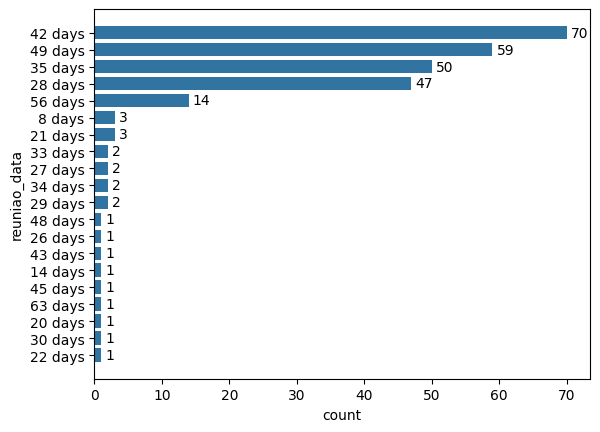

In [28]:
fig, ax = plt.subplots()
sns.barplot(intermeeting_days.value_counts(), orient = 'h', ax = ax)
ax.bar_label(ax.containers[0], fmt=lambda x: int(x), padding = 3)
plt.plot()

The highest ocurrence of days betweeen meetings was 42, closely followed by 49. Let's check the mean and the median.

In [29]:
intermeeting_days.agg(['mean', 'median']).to_frame()

reuniao_data
mean   39 days 06:12:19.163498099
median           42 days 00:00:00

The average days between meetings is 39, and the median is 42 days, This is probably a consequence of some meetings being only 8 days apart.

<Axes: ylabel='reuniao_data'>

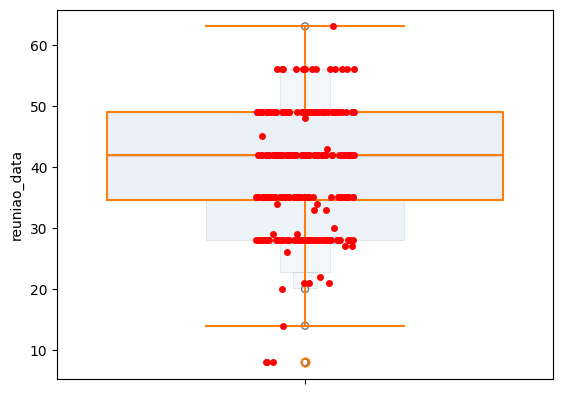

In [30]:
intermeeting_days = (intermeeting_days.astype('str').str.split().str[0]).astype('int')
ax = sns.boxenplot(intermeeting_days, alpha= 0.1)
sns.boxplot(intermeeting_days, fill = False, ax = ax)
sns.stripplot(intermeeting_days, color = 'red', ax = ax)

From the above plot, we can tell at least three outliers. These outliers are clearly related to the 8 days between meetings. But to be sure, let's identify them.

In [31]:
def boxplot_outlier_filter(data: pd.Series) -> pd.Series:
    '''Returns a filter to isolate the outliers
    
    Parameters:
    ---
    data: pd.Series
        Data to be filtered

    Returns:
    ---
    pd.Series:
        Boolean series where True is an outlier and False isn't
    '''
    data_mean = data.mean()
    data_quartsup = data.quantile(.75)
    data_quartinf = data.quantile(.25)
    data_interquartile = data_quartsup - data_quartinf
    factor = 1.5

    filter_sup = (data > data_quartinf + (factor * data_interquartile)) 
    filter_inf = (data < data_quartinf - (factor * data_interquartile)) 

    return filter_sup | filter_inf

In [32]:
intermeeting_outliers = intermeeting_days[boxplot_outlier_filter(intermeeting_days)].to_frame()
intermeeting_outliers = intermeeting_outliers.rename(columns = {intermeeting_outliers.columns[0]: 'intrareuniao_outlier'})
intermeeting_outliers

intrareuniao_outlier
58                     63
193                     8
250                     8
260                     8

In reality, we have 4 outliers. I can't deny that 8 days between meeting makes me relate them to extraordinary meetings.

In [33]:
intermeeting_outlier_filter = boxplot_outlier_filter(intermeeting_days).reindex(np.arange(0, len(selic_df)), fill_value = False)
selic_df[intermeeting_outlier_filter]

reuniao_num reuniao_data reuniao_vies  meta_selic_pctaa  tban_pctam   
58           211ª   2017-12-06     sem viés               7.0         NaN  \
193   76ª ex. (8)   2002-10-14     sem viés              21.0         NaN   
250           27ª   1998-09-02          n/a              19.0       29.75   
260       17ª (7)   1997-10-22          n/a               1.0        1.00   

     taxa_selic_pct  taxa_selic_pctaa vigencia_inicio vigencia_fim   
58             1.15              6.90      2017-12-07   2018-02-07  \
193            0.53             20.90      2002-10-15   2002-10-22   
250            0.45             25.49      1998-09-03   1998-09-10   
260            3.04             45.90      1997-11-01   1997-11-30   

    data_comunicao_decisao_vies  
58                          NaT  
193                         NaT  
250                         NaT  
260                         NaT

Let's look at these indices' neighbors

In [34]:
intermeeting_outliers_idx = intermeeting_outliers.index
intermeeting_outliers_idxvizinhos = []

for i in intermeeting_outliers_idx:
    if i > 0 and i <= len(selic_df):
        intermeeting_outliers_idxvizinhos.extend([i - 1, i, i + 1])

selic_df.loc[intermeeting_outliers_idxvizinhos, :]

reuniao_num reuniao_data reuniao_vies  meta_selic_pctaa  tban_pctam   
57           212ª   2018-02-07          n/a              6.75         NaN  \
58           211ª   2017-12-06     sem viés              7.00         NaN   
59           210ª   2017-10-25     sem viés              7.50         NaN   
192           77ª   2002-10-22     sem viés             21.00         NaN   
193   76ª ex. (8)   2002-10-14     sem viés             21.00         NaN   
194           75ª   2002-09-18     sem viés             18.00         NaN   
249   28ª ex. (8)   1998-09-10          n/a             19.00       49.75   
250           27ª   1998-09-02          n/a             19.00       29.75   
251           26ª   1998-07-29          n/a             19.75       25.75   
259   18ª ex. (8)   1997-10-30          n/a              3.05        3.23   
260       17ª (7)   1997-10-22          n/a              1.00        1.00   
261           16ª   1997-09-17          n/a              1.58        1.78   

     taxa_selic_pct  taxa_selic_pctaa vigencia_inicio vigencia_fim   
57             0.72              6.65      2018-02-08   2018-03-21  \
58             1.15              6.90      2017-12-07   2018-02-07   
59             0.80              7.40      2017-10-26   2017-12-06   
192            1.44             20.90      2002-10-23   2002-11-20   
193            0.53             20.90      2002-10-15   2002-10-22   
194            1.18             17.90      2002-09-19   2002-10-14   
249            2.58             40.18      1998-09-11   1998-10-07   
250            0.45             25.49      1998-09-03   1998-09-10   
251            1.76             19.25      1998-07-30   1998-09-02   
259            3.18             45.67      1997-10-31   1997-11-30   
260            3.04             45.90      1997-11-01   1997-11-30   
261            1.53             19.05      1997-10-01   1997-10-30   

    data_comunicao_decisao_vies  
57                          NaT  
58                          NaT  
59                          NaT  
192                         NaT  
193                         NaT  
194                         NaT  
249                         NaT  
250                         NaT  
251                         NaT  
259                         NaT  
260                         NaT  
261                         NaT

Looking at the reuniao_num column, after October 22, 1997, there was an extraordinary meeting 8 days later. The same happened after September 2, 2002. On October 14, 2002, there was an extraordinary meeting, the effect of which lasted only 8 days until the meeting on October 22.

After looking into it, I was unable to find why one of the interval between meetings was as long as 63 days.

We can also enrich our analysis by looking at the difference between the meta (target interest rate) and taxa_selic (interest rate). For this, we are going to create a new column called taxaemeta_dif (target_and_interest_diff)

In [35]:
selic_df['taxaemeta_dif'] = selic_df['meta_selic_pctaa'] - selic_df['taxa_selic_pctaa']
selic_df.head()

reuniao_num reuniao_data reuniao_vies  meta_selic_pctaa  tban_pctam   
0        269ª   2025-03-19          n/a             14.25         NaN  \
1        268ª   2025-01-29          n/a             13.25         NaN   
2        267ª   2024-12-11          n/a             12.25         NaN   
3        266ª   2024-11-06          n/a             11.25         NaN   
4        265ª   2024-09-18          n/a             10.75         NaN   

   taxa_selic_pct  taxa_selic_pctaa vigencia_inicio vigencia_fim   
0             NaN               NaN      2025-03-20   2025-05-01  \
1            1.63             13.15      2025-01-30   2025-03-19   
2            1.51             12.15      2024-12-12   2025-01-29   
3            0.97             11.15      2024-11-07   2024-12-11   
4            1.42             10.65      2024-09-19   2024-11-06   

  data_comunicao_decisao_vies  taxaemeta_dif  
0                         NaT            NaN  
1                         NaT            0.1  
2                         NaT            0.1  
3                         NaT            0.1  
4                         NaT            0.1

<Axes: xlabel='vigencia_inicio'>

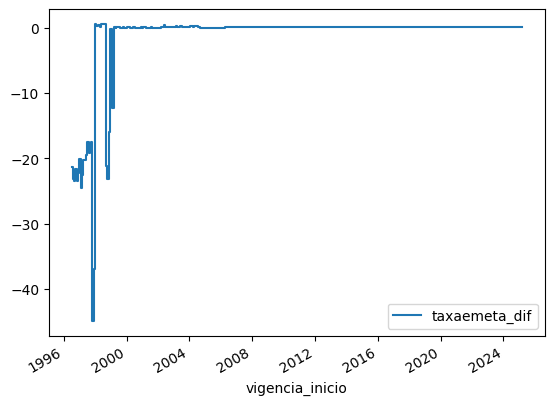

In [36]:
selic_df.plot(x = 'vigencia_inicio', y =  'taxaemeta_dif', drawstyle='steps-post')

It is clear that there were a lot of variation in the 90s while in the 2000s, it became more stable

<Axes: xlabel='vigencia_inicio'>

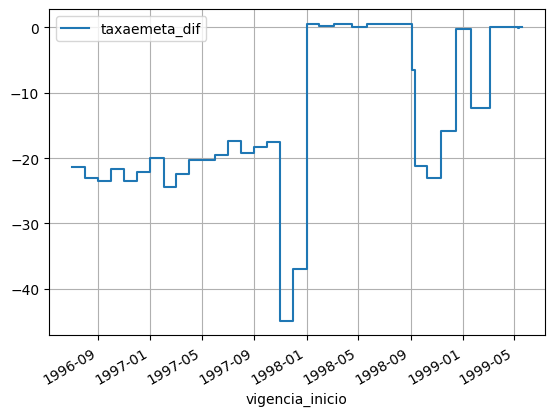

In [37]:
selic_df[selic_df['vigencia_inicio'] < '1999-06']\
    .plot(x = 'vigencia_inicio', y = 'taxaemeta_dif', drawstyle='steps-post', grid=True)

After 1997, the meta (target interest rate) was lower 20 points than the interest rate. At the end of 1997, there was a sudden drop that caused the difference reach 40 percent points. After some complementary research, I could relate this difference to the Hong Kong stock market crash. After this, there was another dip from approximately 0 to 20 percent points, for which I could not find a justification.

<Axes: xlabel='vigencia_inicio'>

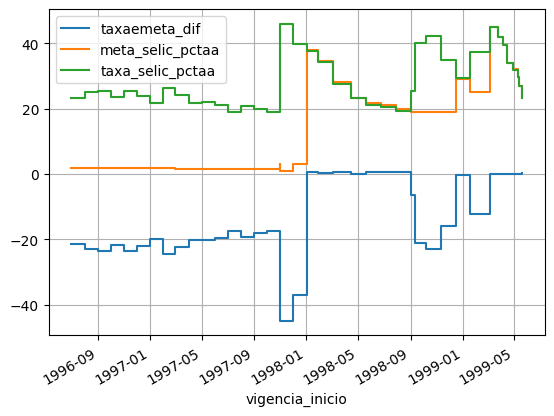

In [38]:
selic_df[selic_df['vigencia_inicio'] < '1999-06'].plot(
    x = 'vigencia_inicio', 
    y =  ['taxaemeta_dif', 'meta_selic_pctaa', 'taxa_selic_pctaa'], 
    drawstyle='steps-post', 
    grid=True
)

From the above plot, we see that the meta (targe interest rate) was poorly set or something is wrong with the data. Refering back to Brazilian Central Bank website, it is reported that there was no target interest rate before March 1999, and these values that are in the column correspond to TBC (Central Bank Base Interest Rate). At the time TBC was used as a lower bound and TBAN served as upper bound for the interest rate bands. The bands were employed to control the interest rate. In addition, the values for TBAN and TBC were monthly until January 1998, while the column in question contains annual values.. So we need to create new columns for these new features.

In [39]:
selic_df['tbc_pctam'] = selic_df.loc[selic_df['reuniao_data'] < '1999-03-04', 'meta_selic_pctaa']
selic_df.loc[selic_df['reuniao_data'] < '1999-03-04', 'meta_selic_pctaa'] = np.nan
selic_df['tbc_pctaa'] = selic_df.loc[selic_df['vigencia_inicio'] >= '1998-01-02', 'tbc_pctam']
selic_df.loc[selic_df['vigencia_inicio'] >= '1998-01-02', 'tbc_pctam'] = np.nan
selic_df['tban_pctaa'] = selic_df.loc[selic_df['vigencia_inicio'] >= '1998-01-02', 'tban_pctam'] 
selic_df.loc[selic_df['vigencia_inicio'] >= '1998-01-02', 'tban_pctam'] = np.nan

We now need to correct the column taxaemeta_did (the difference between target interest rate and the interest rate_

In [40]:
selic_df.loc[selic_df['reuniao_data'] < '1999-03-04', 'taxaemeta_dif'] = np.nan

We revisit the plot taxaemeta_dif and plot a moving avarage and moving standard deviation.

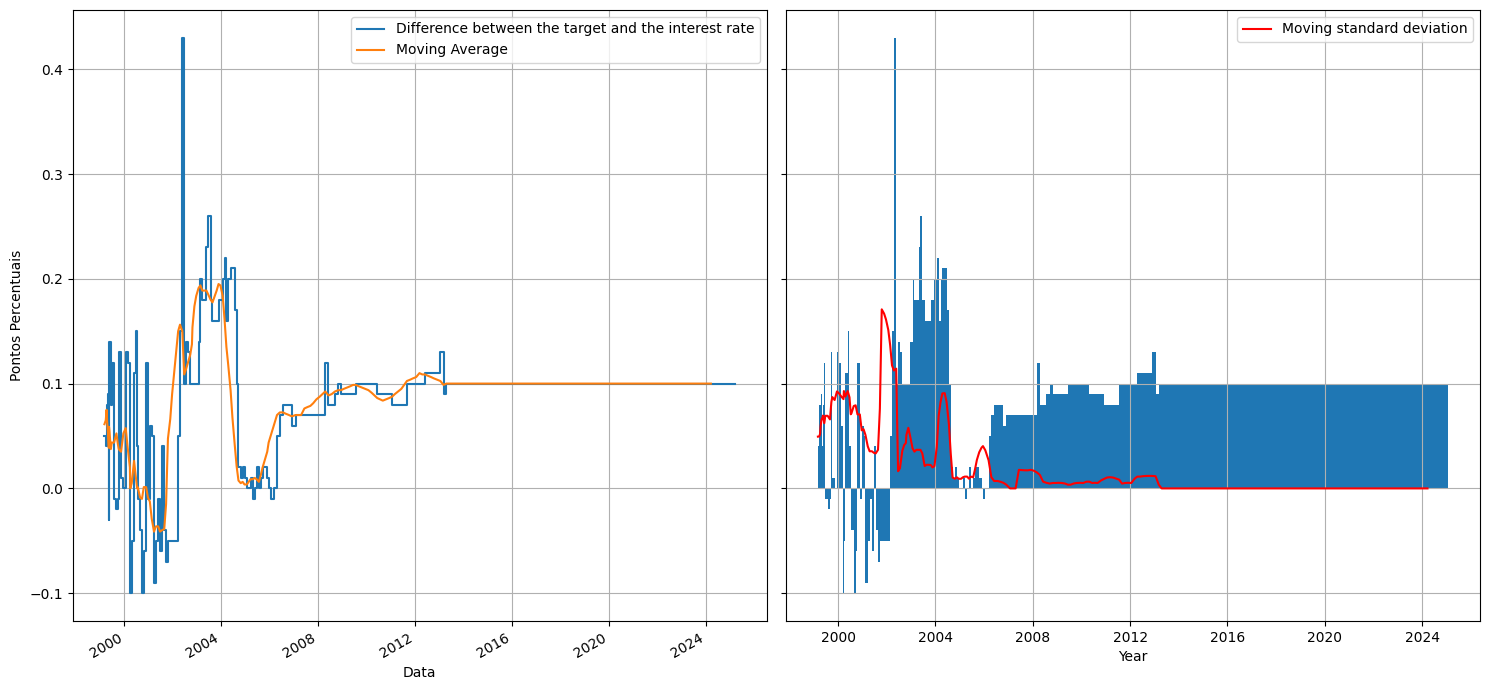

In [41]:
fig, axs = plt.subplots(1, 2, figsize = (15, 7), sharey = True)

selic_df.plot(x = 'vigencia_inicio',  y = 'taxaemeta_dif', drawstyle='steps-post', grid=True, ax = axs[0], label= 'Difference between the target and the interest rate')
axs[0].plot(selic_df.loc[:,'vigencia_inicio'], selic_df.loc[:,'taxaemeta_dif'].rolling(8).mean(), label= 'Moving Average')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Pontos Percentuais')
axs[0].legend()

axs[1].fill_between(selic_df['vigencia_inicio'], selic_df['taxaemeta_dif'], step='post')
axs[1].plot(selic_df.loc[:,'vigencia_inicio'], selic_df.loc[:,'taxaemeta_dif'].rolling(8).std(), 'r-', label= 'Moving standard deviation')
axs[1].set_xlabel('Data')
axs[1].grid()
axs[1].legend()


fig.tight_layout()
plt.ylabel('Percent Point')
plt.xlabel('Year')
plt.show()

We now can see that before 2014, there was significant variation in the difference between the target interest rate and the actual interest rate, while after that, it stabilized at 0.1. It is clear that in 2001, the interest rate exceeded the target. After that, the difference increased to 0.2 percent points and then dipped to 0. After 2006, we observe the difference gradually tending toward 0.1, eventually stabilizing.

Now that we created the columns for the interest rate bands, we could try to visualize it

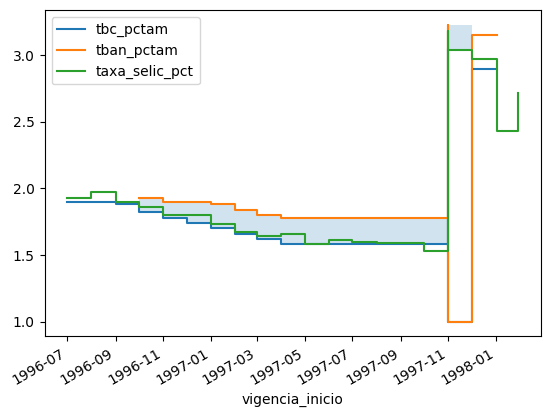

In [42]:
fig, ax = plt.subplots()
selic_df.plot(
    x = 'vigencia_inicio', 
    y =  ['tbc_pctam', 'tban_pctam'], 
    drawstyle='steps-post', 
    grid=True,
    ax = ax
)
selic_df[selic_df['vigencia_inicio'] < '02/01/98'].plot(
    x = 'vigencia_inicio', 
    y = 'taxa_selic_pct', 
    drawstyle='steps-post', 
    ax = ax)
ax.fill_between(selic_df['vigencia_inicio'], selic_df['tbc_pctam'], selic_df['tban_pctam'], alpha= .2, step='pre')

The data appears to be incorrect when we look in November 1997. It is the same date the we detected earlier where we found inconsistencies in the dates.

In [43]:
selic_df[selic_df['reuniao_data'] ==  '1997-10-22'][['reuniao_data', 'tban_pctam', 'tbc_pctam']]

reuniao_data  tban_pctam  tbc_pctam
260   1997-10-22         1.0        1.0

After researching this date, I found that these values did not come into effect. So we can remove this row.

In [44]:
selic_df = selic_df.drop(selic_df[selic_df['reuniao_data'] ==  '1997-10-22'].index, axis = 0)

We plot now with interest rate bands.

[]

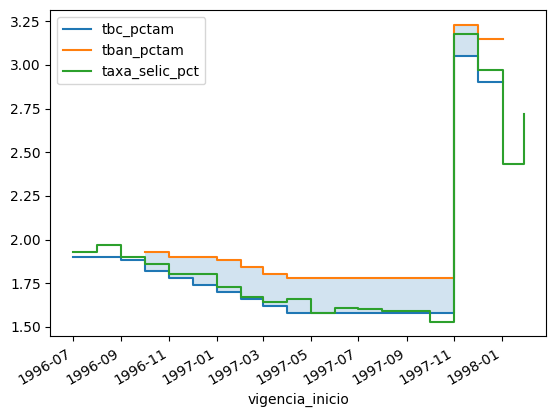

In [45]:
fig, ax = plt.subplots()
selic_df.plot(
    x = 'vigencia_inicio', 
    y =  ['tbc_pctam', 'tban_pctam'], 
    drawstyle='steps-post', 
    grid=True,
    ax = ax
)
selic_df[selic_df['vigencia_inicio'] < '02/01/98'].plot(
    x = 'vigencia_inicio', 
    y = 'taxa_selic_pct', 
    drawstyle='steps-post', 
    ax = ax)
ax.fill_between(selic_df['vigencia_inicio'], selic_df['tbc_pctam'], selic_df['tban_pctam'], alpha= .2, step='pre')
plt.plot()

We see that the interest rate tended towards the the TBC values, that is, the lower bound. In November 1997, we observe a abrupt increase due to Hong Kong market crash.

In [46]:
selic_df.query('taxa_selic_pct < tbc_pctam')

reuniao_num reuniao_data reuniao_vies  meta_selic_pctaa  tban_pctam   
261         16ª   1997-09-17          n/a               NaN        1.78  \

     taxa_selic_pct  taxa_selic_pctaa vigencia_inicio vigencia_fim   
261            1.53             19.05      1997-10-01   1997-10-30  \

    data_comunicao_decisao_vies  taxaemeta_dif  tbc_pctam  tbc_pctaa   
261                         NaT            NaN       1.58        NaN  \

     tban_pctaa  
261         NaN

Let's visualize the period when both TBAN and TBC were annualized

[]

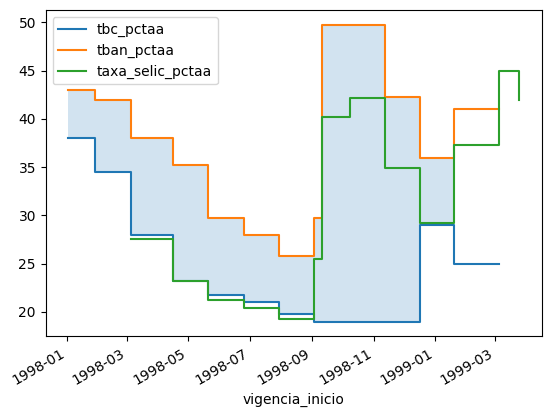

In [47]:
fig, ax = plt.subplots()
selic_df.plot(
    x = 'vigencia_inicio', 
    y =  ['tbc_pctaa', 'tban_pctaa'], 
    drawstyle='steps-post', 
    grid=True,
    ax = ax
)
selic_df.query('vigencia_inicio > "02/01/98" & vigencia_inicio < "4/3/99"').plot(
    x = 'vigencia_inicio', 
    y = 'taxa_selic_pctaa', 
    drawstyle='steps-post', 
    ax = ax)
ax.fill_between(selic_df['vigencia_inicio'], selic_df['tbc_pctaa'], selic_df['tban_pctaa'], alpha= .2, step='pre')
plt.plot()

During the period when the rates were annualized, we can see that the interest rate was outside the interest bands on a few occasions, which means that the interest rate was not controlled by the set bands. Let's count how many periods it was outside the interest rate bands.

In [48]:
len(selic_df.query('taxa_selic_pctaa < tbc_pctaa | tban_pctaa < taxa_selic_pctaa'))

7

7 times in a small period of time.

Back at data transformation, we can see that we don't have an evenly spaced data, because the days between meetings varies. Therefore we need to make it evenly by turning it into monthly data. To do that we are going to leverage the taxa_selic_pctaa column, which is the annual inflation rate and is annualized using 252 days. To do this, we first compute the factors of each working day.

In [49]:
resampled_selic_df = selic_df[['vigencia_inicio', 'taxa_selic_pctaa', 'meta_selic_pctaa']]\
    .set_index('vigencia_inicio')\
    .apply(lambda x: np.power(1 + x/100, 1/252))\
    .resample('B')\
    .ffill()

resampled_selic_df.tail()

taxa_selic_pctaa  meta_selic_pctaa
vigencia_inicio                                    
2025-03-14                1.00049          1.000494
2025-03-17                1.00049          1.000494
2025-03-18                1.00049          1.000494
2025-03-19                1.00049          1.000494
2025-03-20                    NaN          1.000529

We just converted the value to daily using $\textrm{daily factor} = (1 + \textrm{annual interest rate})^{1/252}$

In addition to considering only working days, we also need to exclude brazilian holydays so we can get monthly values.

Refering to the <a href="https://www.bcb.gov.br/cidadaniafinanceira/direitosdeveres"> BCB (Brazilian Central Bank) website</a>, besides the usual brazilian holidays, the following days are also considered holidays.

* Brazilian carnival dates (monday and tuesday)
* second day of November

I collected those days using the script scrap_feriados.py and I stored the data in the feriados.csv file.

In [50]:
holidays_df = pd.read_csv('data/feriados.csv')

In [51]:
for feriado in holidays_df:
    holidays_df[feriado] = pd.to_datetime(holidays_df[feriado])

In [52]:
holidays_df = holidays_df.unstack().to_frame().set_index(0)

Using the daily factor we multiply by the number of days in each month and subytract by 1 to get the monthly values. We multiply by 100 to get in percent.

In [53]:
monthly_selic_df = resampled_selic_df[~resampled_selic_df.index.isin(holidays_df.index)]\
    .resample('M')\
    .prod()\
    .apply(lambda x: (x - 1) * 100)
monthly_selic_df = monthly_selic_df.iloc[:-1, :]
monthly_selic_df.head()

taxa_selic_pctaa  meta_selic_pctaa
vigencia_inicio                                    
1996-07-31               1.928529               0.0
1996-08-31               1.967890               0.0
1996-09-30               1.904054               0.0
1996-10-31               1.943610               0.0
1996-11-30               1.804187               0.0

Since the current month may be incomplete, we skip it. Additionally, the index doesn't represent a specific date but rather a monthly period, so we adjust it.

In [54]:
monthly_selic_df.index = monthly_selic_df.index.to_period()
monthly_selic_df = monthly_selic_df.reset_index()
monthly_selic_df = monthly_selic_df.rename(columns = {
    'vigencia_inicio': 'periodo_mes',
    'meta_selic_pctaa': 'meta_acumulada_mes', 
    'taxa_selic_pctaa': 'selic_acumulada_mes'
})
monthly_selic_df.head()

periodo_mes  selic_acumulada_mes  meta_acumulada_mes
0     1996-07             1.928529                 0.0
1     1996-08             1.967890                 0.0
2     1996-09             1.904054                 0.0
3     1996-10             1.943610                 0.0
4     1996-11             1.804187                 0.0

From the above table, we can see that the meta contains the number 0 in dates where it didn't exist. This is due to the transformation that we applied to convert to daily interest rate into monthly interest rate. We can replace them with NaN.

In [55]:
monthly_selic_df['meta_acumulada_mes'] = monthly_selic_df['meta_acumulada_mes'].replace(0, np.nan)

We also create an annual table

In [56]:
annual_selic_df = resampled_selic_df[~resampled_selic_df.index.isin(holidays_df.index)]\
    .resample('Y')\
    .prod()\
    .apply(lambda x: (x - 1) * 100)
annual_selic_df = annual_selic_df.reset_index()
annual_selic_df = annual_selic_df.rename(columns = {
    'vigencia_inicio': 'ano',
    'taxa_selic_pctaa': 'selic_acumulada_ano',
    'meta_selic_pctaa': 'meta_acumulada_ano'
})
annual_selic_df['ano'] = annual_selic_df['ano'].dt.year
annual_selic_df = annual_selic_df.iloc[:-1, :]
annual_selic_df['meta_selic_ano'] = annual_selic_df['meta_acumulada_ano'].replace(0, np.nan)
annual_selic_df.head()

ano  selic_acumulada_ano  meta_acumulada_ano  meta_selic_ano
0  1996            11.903565            0.000000             NaN
1  1997            24.895246            0.000000             NaN
2  1998            28.920267            0.000000             NaN
3  1999            25.753425           19.637241       19.637241
4  2000            17.433384           17.453366       17.453366

<hr>

<h3><span id='IPCA'></span>2. IPCA</h3>

We also have to extract the IPCA data (Inflation rate). It can be found on <a href= 'https://ftp.ibge.gov.br/Precos_Indices_de_Precos_ao_Consumidor/IPCA/Serie_Historica/ipca_SerieHist.zip'>IBGE website</a>

In [57]:
import requests
from io import BytesIO
from zipfile import ZipFile

In [58]:
ipca_url = "https://ftp.ibge.gov.br/Precos_Indices_de_Precos_ao_Consumidor/IPCA/Serie_Historica/ipca_SerieHist.zip"
file = requests.get(ipca_url).content
file_bytes = BytesIO(file)

unzipped = ZipFile(file_bytes)
ipca_file = unzipped.namelist()[0]

In [59]:
ipca_df = pd.read_excel(BytesIO(unzipped.read(ipca_file)))
ipca_df.head(10)

Unnamed: 0 Unnamed: 1      Unnamed: 2 Unnamed: 3 Unnamed: 4   
0  SÉRIE HISTÓRICA DO IPCA        NaN             NaN        NaN        NaN  \
1                      NaN        NaN             NaN        NaN        NaN   
2                      NaN        NaN             NaN        NaN        NaN   
3                      ANO        MÊS   NÚMERO ÍNDICE        (%)        NaN   
4                      NaN        NaN  (DEZ 93 = 100)         NO          3   
5                      NaN        NaN             NaN        MÊS      MESES   
6                      NaN        NaN             NaN        NaN        NaN   
7                     1994        JAN          141.31      41.31     162.13   
8                      NaN        FEV          198.22      40.27     171.24   
9                      NaN        MAR          282.96      42.75     182.96   

     Unnamed: 5 Unnamed: 6  Unnamed: 7  
0           NaN        NaN         NaN  
1           NaN        NaN  (continua)  
2      VARIAÇÃO        NaN         NaN  
3           NaN        NaN         NaN  
4             6         NO          12  
5         MESES        ANO       MESES  
6           NaN        NaN         NaN  
7        533.33      41.31     2693.84  
8        568.17      98.22     3035.71  
9        602.93     182.96     3417.39

We can see that the formatting is not good. After a close inspection, we may be able to filter the data and create a more readable table.

In [60]:
ipca_df = ipca_df[ipca_df.isnull().sum(axis = 'columns') <= 1].reset_index(drop=True)
ipca_df_cols = [
    'ano',
    'mes',
    'ipca_numero_indice',
    'ipca_var_mensal',
    'ipca_var_trimestral',
    'ipca_var_semetral',
    'ipca_no_ano',
    'ipca_acumulado_ano'
]
ipca_df.columns = ipca_df_cols
ipca_df.head()

ano  mes ipca_numero_indice ipca_var_mensal ipca_var_trimestral   
0  1994  JAN             141.31           41.31              162.13  \
1   NaN  FEV             198.22           40.27              171.24   
2   NaN  MAR             282.96           42.75              182.96   
3   NaN  ABR             403.73           42.68              185.71   
4   NaN  MAI             581.49           44.03              193.36   

  ipca_var_semetral ipca_no_ano ipca_acumulado_ano  
0            533.33       41.31            2693.84  
1            568.17       98.22            3035.71  
2            602.93      182.96            3417.39  
3            648.92      303.73            3828.49  
4            695.71      481.49            4331.19

I realized that the data was available in rows with at most one null value, and this value was in the 'year' column. Let's check the null values

In [61]:
ipca_df.isnull().sum()[ipca_df.isnull().sum() > 0]

ano    343
dtype: int64

Only in the column ano(year). We will forward fill the missing years  

In [62]:
ipca_df['ano'] = ipca_df['ano'].ffill().astype('str')
ipca_df.head()

ano  mes ipca_numero_indice ipca_var_mensal ipca_var_trimestral   
0  1994  JAN             141.31           41.31              162.13  \
1  1994  FEV             198.22           40.27              171.24   
2  1994  MAR             282.96           42.75              182.96   
3  1994  ABR             403.73           42.68              185.71   
4  1994  MAI             581.49           44.03              193.36   

  ipca_var_semetral ipca_no_ano ipca_acumulado_ano  
0            533.33       41.31            2693.84  
1            568.17       98.22            3035.71  
2            602.93      182.96            3417.39  
3            648.92      303.73            3828.49  
4            695.71      481.49            4331.19

<h4><span id='SobreIPCA'></span>About the dataset: IPCA</h4>

| Variable   | Description                                                                                                |
|-----------------------|-------------------------------------------------------------------------------------------|
| ano                   | 4-digit numeric year.                                                            |
| mes                   | The first three letters of the respective month                     |
| ipca_numero_indice    | Weighted arithmetic average of the 16 monthly average Brazilian metropolitan indeces, computed using the Laspeyres Formula |
| ipca_var_mensal       | Monthly variation of the IPCA index over a month     |
| ipca_var_trimestral   | Quarterly variation of the index considering the last 3 months  |
| ipca_var_semetral     | Six-month change in the index over the last 6 months. |
| ipca_no_ano           | IPCA index variation in the reference month compared to the index in December of the previous year, for the reference year. |
ipca_acumulado_ano    | Annual variation sum over 12 months                                              | 

The monthly IPCA index variation is the Brazilian inflation rate

Let's check the types

In [63]:
ipca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ano                  375 non-null    object
 1   mes                  375 non-null    object
 2   ipca_numero_indice   375 non-null    object
 3   ipca_var_mensal      375 non-null    object
 4   ipca_var_trimestral  375 non-null    object
 5   ipca_var_semetral    375 non-null    object
 6   ipca_no_ano          375 non-null    object
 7   ipca_acumulado_ano   375 non-null    object
dtypes: object(8)
memory usage: 23.6+ KB


In [64]:
dfcols_type(ipca_df)

{'ano': {str},
 'mes': {str},
 'ipca_numero_indice': {float, int},
 'ipca_var_mensal': {float, int},
 'ipca_var_trimestral': {float, int},
 'ipca_var_semetral': {float, int},
 'ipca_no_ano': {float, int},
 'ipca_acumulado_ano': {float, int}}

As we can see, we have only two columns that are not mixed types. Before casting each column to their respective correct type, we will create a new mes (month) column where the months are the three-first-letters string.

In [65]:
meses_numcap = {
    'JAN': '1',
    'FEV': '2',
    'MAR': '3',
    'ABR': '4',
    'MAI': '5',
    'JUN': '6',
    'JUL': '7',
    'AGO': '8',
    'SET': '9',
    'OUT': '10',
    'NOV': '11',
    'DEZ': '12'
}

In [66]:
ipca_df['mes_num'] = ipca_df['mes'].map(meses_numcap)
ipca_df['periodo_mes'] = ipca_df['ano'] + '-' + ipca_df['mes_num']

ipca_df['periodo_mes'] = pd.PeriodIndex(ipca_df['periodo_mes'], freq='M')
ipca_df.head()

ano  mes ipca_numero_indice ipca_var_mensal ipca_var_trimestral   
0  1994  JAN             141.31           41.31              162.13  \
1  1994  FEV             198.22           40.27              171.24   
2  1994  MAR             282.96           42.75              182.96   
3  1994  ABR             403.73           42.68              185.71   
4  1994  MAI             581.49           44.03              193.36   

  ipca_var_semetral ipca_no_ano ipca_acumulado_ano mes_num periodo_mes  
0            533.33       41.31            2693.84       1     1994-01  
1            568.17       98.22            3035.71       2     1994-02  
2            602.93      182.96            3417.39       3     1994-03  
3            648.92      303.73            3828.49       4     1994-04  
4            695.71      481.49            4331.19       5     1994-05

We set the data types for numeric values.

In [67]:
for ii in range(len(ipca_df.columns) - 1):
    if ii == 1:
        continue
    ipca_df[ipca_df.columns[ii]] = pd.to_numeric(ipca_df[ipca_df.columns[ii]])
ipca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   ano                  375 non-null    int64    
 1   mes                  375 non-null    object   
 2   ipca_numero_indice   375 non-null    float64  
 3   ipca_var_mensal      375 non-null    float64  
 4   ipca_var_trimestral  375 non-null    float64  
 5   ipca_var_semetral    375 non-null    float64  
 6   ipca_no_ano          375 non-null    float64  
 7   ipca_acumulado_ano   375 non-null    float64  
 8   mes_num              375 non-null    int64    
 9   periodo_mes          375 non-null    period[M]
dtypes: float64(6), int64(2), object(1), period[M](1)
memory usage: 29.4+ KB


We rename the column ipca_var_mensal so we can shortten it to only ipca_mes

In [68]:
ipca_df = ipca_df.rename(columns =  {
    'ipca_var_mensal' : 'ipca_mes'
})

We create the decada (decade) column.

In [69]:
ipca_df['decada'] = (np.floor(ipca_df['ano'] / 10) * 10).astype('int')

We can now limit the features to the features of interes.

In [70]:
ipca_mensal_df = ipca_df[['periodo_mes', 'mes', 'ano', 'decada' ,'ipca_mes']]
ipca_mensal_df.head()

periodo_mes  mes   ano  decada  ipca_mes
0     1994-01  JAN  1994    1990     41.31
1     1994-02  FEV  1994    1990     40.27
2     1994-03  MAR  1994    1990     42.75
3     1994-04  ABR  1994    1990     42.68
4     1994-05  MAI  1994    1990     44.03

We finally create the yearly version

In [71]:
ipca_anual_df = ipca_df.groupby('ano')[['ipca_acumulado_ano', 'decada']].last().reset_index()

<hr></hr>
We merge the selic and the ipca monthly data

In [72]:
merged_monthly_df = monthly_selic_df.merge(ipca_mensal_df, how='inner', on='periodo_mes')
merged_monthly_df.head()

periodo_mes  selic_acumulada_mes  meta_acumulada_mes  mes   ano  decada   
0     1996-07             1.928529                 NaN  JUL  1996    1990  \
1     1996-08             1.967890                 NaN  AGO  1996    1990   
2     1996-09             1.904054                 NaN  SET  1996    1990   
3     1996-10             1.943610                 NaN  OUT  1996    1990   
4     1996-11             1.804187                 NaN  NOV  1996    1990   

   ipca_mes  
0      1.11  
1      0.44  
2      0.15  
3      0.30  
4      0.32

In [73]:
merged_monthly_df = merged_monthly_df[[
    'periodo_mes', 
    'mes', 
    'ano', 
    'decada', 
    'meta_acumulada_mes', 
    'selic_acumulada_mes', 
    'ipca_mes'
]]

We save as a tsv file.

In [74]:
merged_monthly_df.to_csv('data/selic_ipca_mes.tsv', sep = '\t', index =  False)

We do the same for the ipca.

In [75]:
merged_annual_df = annual_selic_df.merge(
    ipca_anual_df, how='inner', on='ano', 
)

In [76]:
merged_annual_df = merged_annual_df[['ano', 'decada', 'meta_selic_ano', 'selic_acumulada_ano', 'ipca_acumulado_ano']]

In [77]:
merged_annual_df.to_csv('data/selic_ipca_ano.tsv', sep = '\t', index = False)